<a href="https://colab.research.google.com/github/christakahashi/ECE447/blob/master/lectures/root-locus-design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ECE 447: Root Locus Design
===

Updated by 
 Dr. Chris Takahashi

Authored by Prof. Eric Klavins &copy; 2019, University of Washington


# Code

In [1]:
!pip install control
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from sympy import *
from control import *

%matplotlib inline
#comment out for light mode
plt.style.use('dark_background')

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')

     |████████████████████████████████| 256kB 4.2MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=5936cbec94157a975f56133774576360595ff8c4a983fdfd2b8a36a9ce5e8956
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control


# Goal

The goal with root locus based design is to design a controller $G_c(s)$ to alter the shape of the root locus so that a gain $K$ can be chosen to give the desired performance. In the diagram below, the system with $KG(s)$ has marginally stable poles no matter what $K$ you choose. By adding a zero and remembering that the root locus goes from the poles to the zeros, we get as root locus for $KG_c(s)G(s)$ that can contains a variety of stable poles for different values of the gain $K$. 

<img width=55% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/root-locus-design.png">

# Examples

Example: PI Control
---

A Proportional-Integral controller has the form

$$
G_c(s) = \frac{K_I}{s} + K_p
$$

which can be rewritten

$$
G_c(s) = \frac{K_p\left(s+\frac{K_I}{K_p}\right)}{s}
$$

Thus, PI control is adding a new pole at 0 and a new zero at $-\frac{K_I}{K_p}$. 

Example: PI Control of a Simple System
---

Suppose $G(s) = \frac{1}{s}$

<img width=55% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/root-locus-pi.png">

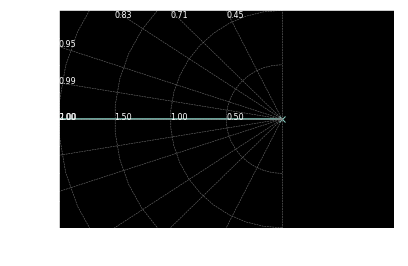

In [2]:
# Simple control: Only totally damped response possible
sys1 = tf([1],[1,0])
r,k = root_locus(sys1,xlim=(-2,1))

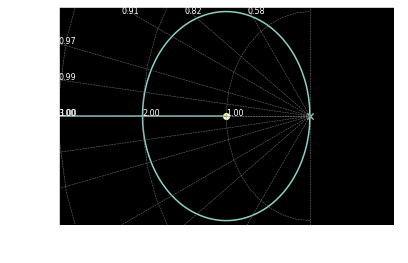

In [3]:
# PI control: A range of gains possible
z = -1
sys1 = tf([1,-z],[1,0,0])
r,k = root_locus(sys1,xlim=(-3,1))

Example: PID Control
---

A Proportional-Integral-Derivative controller has the form

$$
G_c(s) = K_p + K_D s + \frac{K_I}{s}
$$

which can be written

\begin{align}
G_c(s) & = \frac{K_D s^2 + K_p s + K_I}{s^2} \\
       & = K_d \frac{(p+z_1)(p+z_2)}{s^2}
\end{align}

Therefore, a PID controller amounts to picking two zero locations and placing to poles at zero. 

Example: PID Design
---

Suppose we wish to control the system

$$
G(s) = \frac{1}{s^2+2s+2}
$$

which has poles at $-1 \pm i$. Without a controller, the root locus looks like the following:

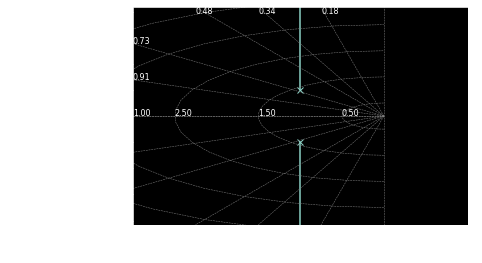

In [4]:
# Gain only, no controller
sys1 = tf([1],[1,2,2])
r,k = root_locus(sys1,xlim=(-3,1))

Now say we want the system to have a settling time of four seconds and a 10% overshoot. Then

$$
\zeta\omega = 4
$$

and

$$
\frac{\zeta\pi}{\beta} = - \ln (0.1)
$$

Solving the above gives:

In [5]:
var("s zeta omega")
sol=solve([zeta*omega-4, zeta*pi/sqrt(1-zeta**2)-log(0.1)])[0]
sol

{ω: -6.76641451278031, ζ: -0.591155033798898}

Putting these values into

$$
s^2 + 2 \zeta \omega s + \omega^2
$$

and solving for $s$ gives us the desired denominator of $T(s):

In [6]:
den = (s**2 + 2*zeta*omega*s + omega**2).subs(sol)
den

 2                          
s  + 8.0⋅s + 45.784365358764

That is, we want to place the poles of $T(s)$ at

In [7]:
den = (s**2 + 2*zeta*omega*s + omega**2).subs(sol)
poles = solve(den,s)
poles

[-4.0 - 5.45750541536735⋅ⅈ, -4.0 + 5.45750541536735⋅ⅈ]

We can't place the poles anywhere, but we do know that as $K$ goes to $\infty$, the root locus goes to the zeros. So we can define a PID controller by

$$
K_D \frac{s^2 + 2 \zeta \omega s + \omega^2}{s}
$$

or in this case

In [8]:
Gc = den / s
Gc

 2                          
s  + 8.0⋅s + 45.784365358764
────────────────────────────
             s              

In [9]:
G = 1 / ( s**2 + 2*s + 2 )
GcG = Gc*G
GcG.cancel()

    ⎛     2                          ⎞
1.0⋅⎝1.0⋅s  + 8.0⋅s + 45.784365358764⎠
──────────────────────────────────────
            3        2                
       1.0⋅s  + 2.0⋅s  + 2.0⋅s        

In [10]:
var("K")
T = K * Gc * G / ( 1 + K * Gc * G)
T.cancel()
num,den=fraction(T)
solve(den.subs(K,100))

[-93.9850499518698, -4.00747502406511 - 5.71442589384394⋅ⅈ, -4.00747502406511 
+ 5.71442589384394⋅ⅈ]

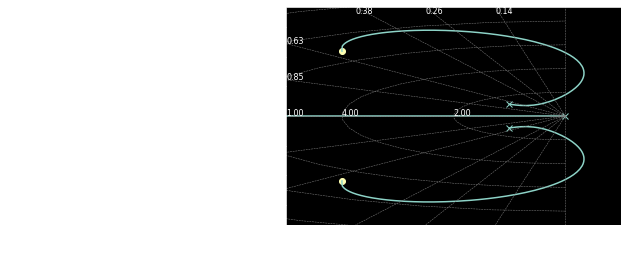

In [11]:
sys = tf([1,8,45.78],[1,2,2,0])
r,k=root_locus(sys,xlim=(-5,1))

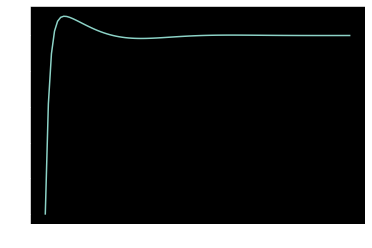

In [12]:
gain = tf([50],[1])
fb = feedback(series(sys,gain))
t,y = step_response(fb)
plt.plot(t,y);

# PID Control One Component at a Time

In [13]:
# Example Plant
G = (s+3) / ((s+1)*(s+2))
G.cancel()

   s + 3    
────────────
 2          
s  + 3⋅s + 2

In [14]:
# Proportional Control
Gc = 1
(Gc*G).cancel()

   s + 3    
────────────
 2          
s  + 3⋅s + 2

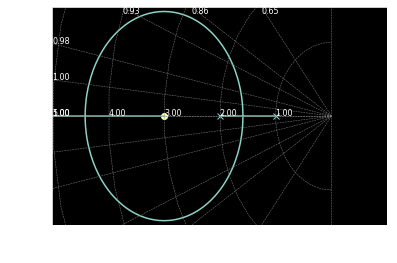

In [15]:
# Proportional Control Root Locus
# Good, but may not be able to get a desired percent overshoot
sys = tf([1,3],[1,3,2])
r,k=root_locus(sys,xlim=(-5,1))

In [16]:
# Derivative control
Gc = s
(Gc*G).cancel()

   2        
  s  + 3⋅s  
────────────
 2          
s  + 3⋅s + 2

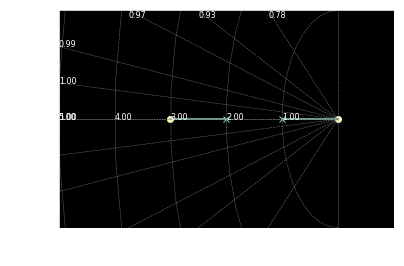

In [17]:
# Derivative Control Root Locus
# No way to get overshoot at all
sys = tf([1,3,0],[1,3,2])
r,k=root_locus(sys,xlim=(-5,1))

In [18]:
# Integral control
Gc = 1/s
(Gc*G).cancel()

     s + 3     
───────────────
 3      2      
s  + 3⋅s  + 2⋅s

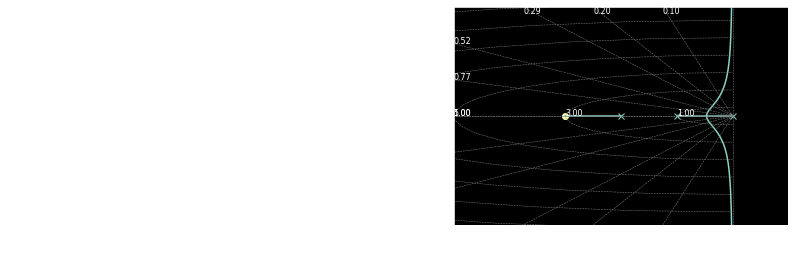

In [19]:
# Integral Control Root Locus
# R.L is too close to imaginary axis for comfort
sys = tf([1,3],[1,3,2,0])
r,k=root_locus(sys,xlim=(-5,1))

In [20]:
# PID control
Gc = 10 + s + 26/s
(Gc*G).cancel()

 3       2            
s  + 13⋅s  + 56⋅s + 78
──────────────────────
    3      2          
   s  + 3⋅s  + 2⋅s    

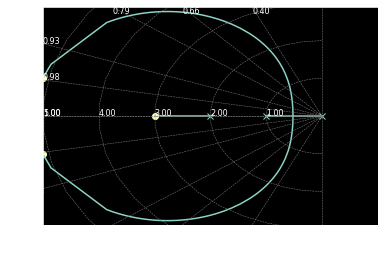

In [21]:
# PID Control Root Locus
# R.L in region with good percent overshoot
sys = tf([1,13,56,78],[1,3,2,0])
r,k=root_locus(sys,xlim=(-5,1))

# Don't cancel poles and zeros


Suppose that 

$$
G(s) = \frac{1}{s^2+1}
$$

which has poles at $\pm i$. To stabilize this system, you might be tempted to put

$$
K G_c(s) = K \frac{s^2+1}{s}
$$

so that

$$
K Gc(s) G(s) = \frac{K}{s}.
$$

This system looks great since you can get any negative real pole you want along the root locus.

However, because $G(s)$ is just a model and possibly inaccurate, you probably would get a root locus more like the following, which is not very stable or even possibly unstable.

In [22]:
G = 1 / ( s**2 - 0.1*s + 1.1) # what you might actually get instead of 
                              # 1 / ( s**2 + 1 )
Gc = (s**2 + 1)/s
Gc*G

        2           
       s  + 1       
────────────────────
  ⎛ 2              ⎞
s⋅⎝s  - 0.1⋅s + 1.1⎠

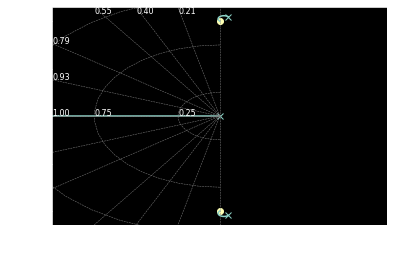

In [23]:
sys = tf([1,0,1],[1,-0.1,1.1,0])
r,k=root_locus(sys,xlim=(-1,1))